In [ ]:
!nvidia-smi

Mon Nov 14 05:36:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Importing  all the necessary packages
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS  = 3
EPOCHS = 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading the dataset.
dataset_path = '/content/drive/MyDrive/SIP/Paddy-Disease-Classification'
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    shuffle = True,
    seed = 123,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6577 files belonging to 9 classes.


In [ ]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'blast',
 'brown_spot',
 'false_smut',
 'normal',
 'sheath_blight',
 'sheath_rot',
 'tungro']

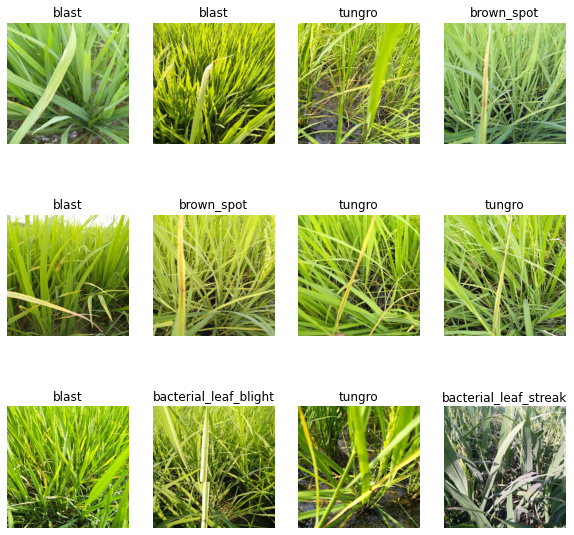

In [ ]:
# Ploting some sample from batch 1:
plt.figure(figsize = (10, 10))
for image, label in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [ ]:
# Dataset Spliting Function.
def dataset_partitions(ds, train_split = 0.7, vali_split = 0.2, test_split = 0.1, shuffle = True, shuffle_size=1000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 123)
        
    dataset_size = len(ds)
    train_size = int(dataset_size*train_split)
    train_ds = ds.take(train_size)
    vali_size = int(dataset_size * vali_split)
    vali_ds = ds.skip(train_size).take(vali_size)
    test_ds = ds.skip(train_size).skip(vali_size)
    return train_ds, vali_ds, test_ds

In [ ]:
# Function Call
train_ds, val_ds, test_ds = dataset_partitions(dataset)


In [ ]:
# resized_and_rescale = tf.keras.Sequential([
#     layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     layers.Rescaling(1.0/255)
# ])

# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2)
# ])

# Data Rescale and Augmentation:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(height_factor=0.4, width_factor=0.4),
    ],
    name="data_augmentation" )

In [ ]:
#Code for Optimization
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# Model Building:
model = Sequential()
# model.add(resized_and_rescale)
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(9, activation="softmax"))
model.build((None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 256, 256, 3)      7         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0

In [ ]:
# Model Compilation
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
# Training
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/100
144/144 [==============================] - 70s 270ms/step - loss: 1.8695 - accuracy: 0.2691 - val_loss: 1.6459 - val_accuracy: 0.3872
Epoch 2/100
144/144 [==============================] - 58s 260ms/step - loss: 1.6327 - accuracy: 0.3597 - val_loss: 1.5005 - val_accuracy: 0.4139
Epoch 3/100
144/144 [==============================] - 56s 248ms/step - loss: 1.5425 - accuracy: 0.4052 - val_loss: 1.5270 - val_accuracy: 0.4444
Epoch 4/100
144/144 [==============================] - 56s 246ms/step - loss: 1.4611 - accuracy: 0.4433 - val_loss: 1.3731 - val_accuracy: 0.4649
Epoch 5/100
144/144 [==============================] - 56s 250ms/step - loss: 1.3878 - accuracy: 0.4685 - val_loss: 1.2669 - val_accuracy: 0.5104
Epoch 6/100
144/144 [==============================] - 56s 254ms/step - loss: 1.3432 - accuracy: 0.4944 - val_loss: 1.2492 - val_accuracy: 0.5267
Epoch 7/100
144/144 [==============================] - 56s 253ms/step - loss: 1.2635 - accuracy: 0.5169 - val_loss: 1.2553 -

In [ ]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

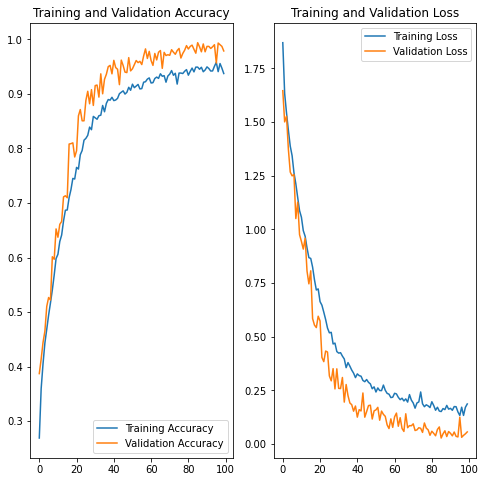

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Saving the model
model_version = 'cnn'
model_path = '/content/drive/MyDrive/SIP/Colab-Codes/Models'
model.save(f"{model_path}/{model_version}")

In [ ]:
# Loading the model
# model_path = '/content/drive/MyDrive/SIP/Colab-Codes/Models/2'
# model = tf.keras.models.load_model(model_path)

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

21/21 [==============================] - 23s 35ms/step - loss: 0.0713 - accuracy: 0.9777


In [35]:
# Printing testing accuracy
print(test_acc)

0.9776785969734192


In [36]:
import seaborn as sns
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [37]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [38]:
labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'blast', 'brown_spot', 'false_smut', 'normal', 'sheath_blight', 'sheath_rot', 'tungro']


144/144 [==============================] - 25s 30ms/step


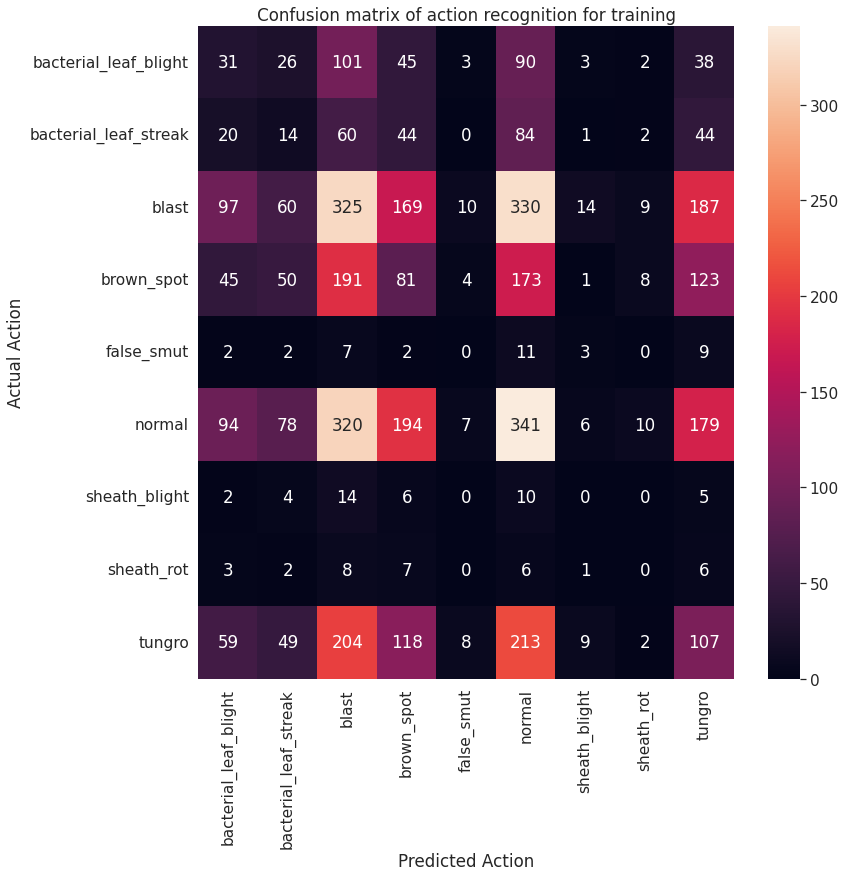

In [39]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

21/21 [==============================] - 21s 31ms/step


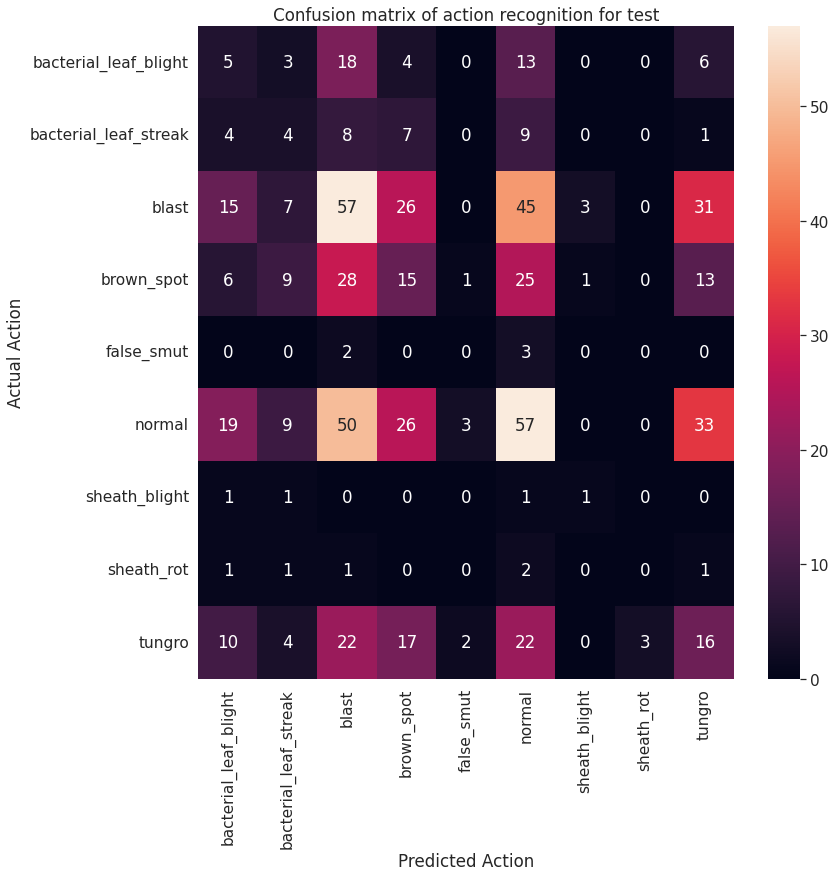

In [40]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')


In [41]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [42]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [43]:
precision

{'bacterial_leaf_blight': 0.08196721311475409,
 'bacterial_leaf_streak': 0.10526315789473684,
 'blast': 0.3064516129032258,
 'brown_spot': 0.15789473684210525,
 'false_smut': 0.0,
 'normal': 0.3220338983050847,
 'sheath_blight': 0.2,
 'sheath_rot': 0.0,
 'tungro': 0.15841584158415842}

In [44]:
recall

{'bacterial_leaf_blight': 0.10204081632653061,
 'bacterial_leaf_streak': 0.12121212121212122,
 'blast': 0.30978260869565216,
 'brown_spot': 0.15306122448979592,
 'false_smut': 0.0,
 'normal': 0.2893401015228426,
 'sheath_blight': 0.25,
 'sheath_rot': 0.0,
 'tungro': 0.16666666666666666}

Actual Label:  blast
1/1 [==============================] - 0s 34ms/step
Predicted Lavel:  blast


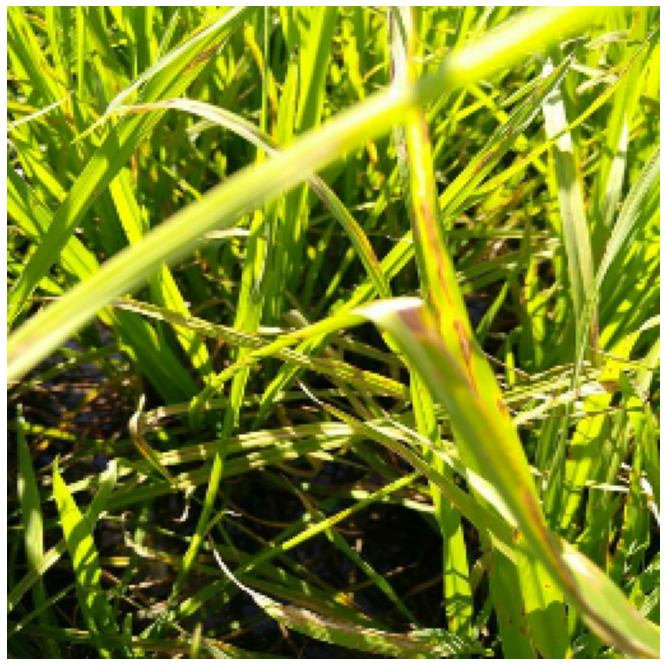

In [45]:
# Chacking via taking 
for images_batch, labels_batch in test_ds.take(1):
    
    img = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()
    plt.imshow(img)
    print("Actual Label: ", class_names[label])
    batch_prediction = model.predict(images_batch)
    maxi = np.argmax(batch_prediction[0])
    print("Predicted Lavel: ", class_names[maxi])
    plt.axis('off')

In [ ]:
def predict(model, img):
    
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # batch creation
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidance = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidance

In [33]:
plt.figure(figsize = (20, 20))
for images, labels in test_ds.take(1):
    for i in range(30):
        plt.subplot(6, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidance = predict(model, images[i].numpy())
        plt.title(f"Actual: {class_names[labels[i]]}, \n Predicted: {predicted_class}. \n Confidence: {confidance}")
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.